# Unsupervised machine learning final assignment 
Name: Hendrik Reitsma

Studentnumber: 444264

Date: 13-06-2022

## 1. Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans

## 2. Read data, join datasets, explore data
Read clinical data:

In [2]:
clinical = pd.read_excel('Lung3.metadata.xls')
clinical = clinical.reset_index(drop=True)

Read gene expression data:

In [3]:
gene = pd.read_csv('GSE58661_series_matrix.txt.gz', sep='\t', comment='!', compression='gzip')
gene = gene.T
gene.columns = gene.iloc[0]
gene = gene[1:]
gene = gene.reset_index()
gene = gene.rename(columns={'index':'ID_REF'})
gene = gene.rename_axis(None, axis=1)
gene = gene.iloc[:,1:]
gene = gene.apply(pd.to_numeric)

Join data sets and check for nan values

In [4]:
df = clinical.join(gene)
df.isnull().sum().sum()

1

In [5]:
df.isnull().sum()[df.isnull().sum() >= 1]

characteristics.tag.tumor.size.maximumdiameter    1
dtype: int64

Only tumor size column has a nan value.

Check for skewness.

In [6]:
## Skewness
skewed_columns = df.skew().sort_values(ascending=False)
skewed_columns = skewed_columns.loc[skewed_columns > 0.5]
skewed_columns

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22064\3788545905.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewed_columns = df.skew().sort_values(ascending=False)


merck-NC_001526_ORF_1178_at    9.014309
merck-NC_001526_ORF_1180_at    8.944469
merck-NC_001526_ORF_1182_at    8.699111
merck-BX648957_at              8.601416
merck-NC_001526_ORF_1179_at    8.505894
                                 ...   
AFFX-BkGr-GC05_at              0.500062
merck2-BC015750_x_at           0.500043
merck-NM_030760_at             0.500015
merck-NM_017805_at             0.500013
merck2-NM_021731_at            0.500011
Length: 23121, dtype: float64

The data is skewed to the right because in some patients the genes are expressed a lot more than the 'normal' patients. This is something we want to predict with our unsupervised learning algorithm.

## 3. Preprocess data 

The histology column has a lot of different values. For more accurate clustering we can simplify this down to a few groups.

In [7]:
df['characteristics.tag.histology'].value_counts()

Squamous Cell Carcinoma, NOS                                            33
Adenocarcinoma, NOS                                                     25
Non-Small Cell                                                           7
Adenocarcinoma, Papillary, NOS                                           4
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Acinar Type                                              3
Solid Type And Acinar                                                    2
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma, Mixed                                                    1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features               1
Squamous Cell Carcinoma, Other (Specify) with adeno features             1
Adenocarcinoma With Mucinous Features                                    1
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features     1
Carcinoma, Large Cell, Ne

In [8]:
## Cluster histology into Squamous Cell Carcinoma and Adenocarcinoma
def define_clusters(df):
    """
    :param: dataframe
    Function that creates clusters based on histology
    :return: dataframe with grouped histology
    """
    df.loc[df['characteristics.tag.histology'].str.contains('Adenocarcinoma'), 'hist_group'] = 'Adenocarcinoma'
    df.loc[df['characteristics.tag.histology'].str.contains('Squamous Cell Carcinoma'), 'hist_group'] = 'Squamous Cell Carcinoma'
    df['hist_group'] = df['hist_group'].fillna(value='Other')
    return df

## Add group column to dataframe
df = define_clusters(df)
df['hist_group'].value_counts()

Adenocarcinoma             42
Squamous Cell Carcinoma    36
Other                      11
Name: hist_group, dtype: int64

In [9]:
## For better clustering we don't use the entries that are not classifiable as Adenocarcinoma or Squamous Cell Carcinoma
df = df[df['hist_group'] != 'Other']
df.reset_index(drop=True, inplace=True)

The data is fairly balanced.

Standardizing the values actually increases noise in the dataset so there will be no scaling performed.

In [10]:
X = df.iloc[:,17:-1]
## No scaling
X = X.values
## Scaling
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)
## Define y
y = df['hist_group']

## 4. Perform Dimensionality reduction
The dataset is highly dimensional (>60000 columns). Some sort of dimensionality reduction will be necessary.

In [11]:
## PCA:
pca = PCA(n_components=.95, svd_solver='auto')
X_PCA = pca.fit_transform(X)
print(pca.explained_variance_ratio_.cumsum())
print(len(pca.explained_variance_ratio_.cumsum()))
X_PCA = pd.DataFrame(data=X_PCA)

[0.1694419  0.24306965 0.29647818 0.34393041 0.38051974 0.41285276
 0.43934787 0.46288232 0.48577414 0.50431265 0.52153529 0.537073
 0.55225623 0.56702496 0.58045343 0.59376595 0.60675217 0.61944818
 0.6313842  0.64304705 0.65449939 0.66549674 0.67633425 0.68639851
 0.69639274 0.70615448 0.71560417 0.72484721 0.73373532 0.74245381
 0.75095907 0.75910076 0.76720112 0.77508247 0.78287903 0.79040294
 0.79783321 0.80519224 0.8123316  0.81931176 0.82625651 0.8329837
 0.83947938 0.84586479 0.85215333 0.85833988 0.86446379 0.87037578
 0.87615777 0.88188821 0.88752498 0.89310295 0.89854753 0.90392409
 0.90923219 0.91450758 0.91959657 0.92459757 0.92953857 0.934365
 0.93913685 0.94374982 0.94826943 0.9527624 ]
64


95% of variance is explained by 64 principle components

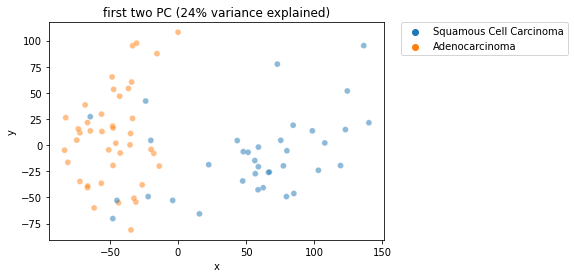

In [12]:
def plot_cluster(X, df, hue):
    #add x, y features to the original df
    df['x'] = X.iloc[:,0]
    df['y'] = X.iloc[:,1]
    sns.scatterplot(x = 'x', y = 'y', hue = hue, data = df, alpha = 0.5, )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title('first two PC (24% variance explained)')
    plt.show()

plot_cluster(X_PCA, df, hue = 'hist_group')

## 5. Perform clustering with kmeans
To distinguish between the different cancers, a clustering technique can be used. First kmeans is explored.

Define analyze cluster function.

In [13]:
# Define analyze cluster function
def analyzeCluster(clusterDF, labelsDF):
    """
    :param: clusterDF, this is the data
            labelsDF, these are the labels
    Function that analyzes clusters and calculates accuracy
    :return: 
            countByCluster, countByLabel, countMostFreq,
            accuracyDF, overallAccuracy, accuracyByLabel
    """
    ## Count number of values in cluster
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']

    ## Reset index if the index don't align
    ## preds shows the true label and what cluster it is assigned to
    clusterDF.reset_index(inplace = True, drop = True)
    labelsDF.reset_index(inplace = True, drop = True)
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    ## Count true labels
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    ## Count the most frequent label
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    ## Merge most frequent occuring label and total cluster size to create accuracyDF
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")

    ## Accuracy is calculated by how many most frequent labels are in the cluster 
    ## divided by total cluster size
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    ## Accuracy per cluster
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

Check how accuracy of clusters improves as number of clusters varies.

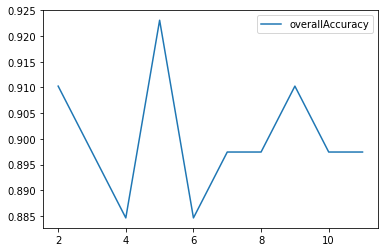

In [14]:
# K-means - Accuracy as the number of clusters varies
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 42

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,16),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,16),columns=['overallAccuracy'])

for n_clusters in range(2,12):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 73
    kmeans.fit(X_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_PCA.index, \
                     columns=['cluster'])
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

# Plot accuracy
overallAccuracy_kMeansDF.plot();

The accuracy of the clusters does not improve after 2 clusters.

In [15]:
# K-means - 2 clusters
n_clusters = 2
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 42

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
            max_iter=max_iter, tol=tol, random_state=random_state)

cutoff = 73
kmeans.fit(X_PCA.loc[:,0:cutoff])
kMeans_inertia.loc[n_clusters] = kmeans.inertia_
X_train_kmeansClustered = kmeans.predict(X_PCA.loc[:,0:cutoff])
X_train_kmeansClustered = \
    pd.DataFrame(data=X_train_kmeansClustered, index=X_PCA.index, \
                    columns=['cluster'])

countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_train_kmeansClustered, y)

overallAccuracy_kMeans

0.9102564102564102

Look inside the kmeans clusters:

In [16]:
check_df = pd.DataFrame(kmeans.labels_)
check_df2 = pd.DataFrame(df['hist_group'])
check_df = check_df.join(check_df2)
check_df[check_df[0] == 0]
check_df[check_df[0] == 1]

,0,hist_group
1,1,Adenocarcinoma
2,1,Adenocarcinoma
4,1,Adenocarcinoma
6,1,Adenocarcinoma
9,1,Adenocarcinoma
11,1,Adenocarcinoma
12,1,Squamous Cell Carcinoma
13,1,Adenocarcinoma
14,1,Adenocarcinoma
17,1,Adenocarcinoma


KMeans is separating the dataset into Squamous cell Carcinoma and Adenocarcinoma pretty well.

## 6. Agglomerative Hierarchical Clustering

Using the observations in the dataset, hierarchical clustering can build a dendrogram. The 'leaves' at the bottom are the individual instances of the dataset. The leaves are joined together based on how similar they are to each other. The most similar instances are joined earlier, and the less similar ones later.

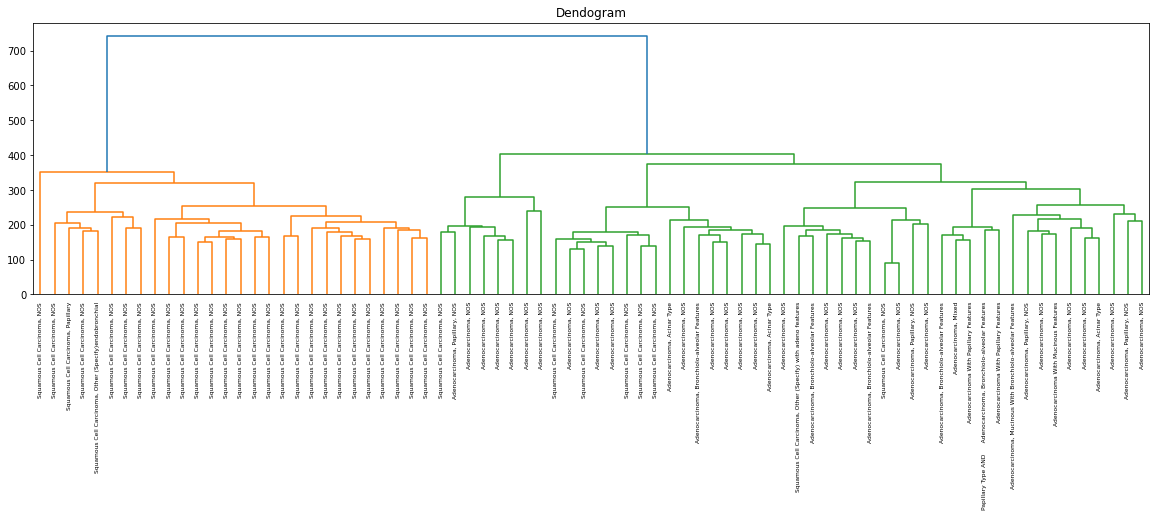

In [17]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 5))
plt.title("Dendogram")
Z = shc.linkage(X, method='ward')
dend = shc.dendrogram(Z,\
                    labels = list(df['characteristics.tag.histology'])
)

In [18]:
# Create clusters
from scipy.cluster.hierarchy import fcluster
distance_threshold = 500
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_PCA.index,columns=['cluster'])

In [19]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_train_hierClustered, y)

overallAccuracy_hierClust

0.8974358974358975

In [20]:
# Show accuracy by cluster
accuracyByLabel_hierClust

0    1.00
1    0.84
dtype: float64

Overall, hierarchical clustering performs well on the dataset. 

## 6. Perform clustering with DBScan
DBScan groups based on the density of points. It will group together closely packed points, where close together is defined as a minimum number of points that must exist within a certain distance.

In [21]:
from sklearn.cluster import DBSCAN
eps = 10
min_samples = 2
leaf_size =30
n_jobs = 8
dbscan = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)
X_PCA_db = dbscan.fit_predict(X_PCA.loc[:,0:cutoff])
X_PCA_db

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [22]:
# Perform DBSCAN with different eps values
from sklearn.cluster import DBSCAN
min_samples = 2
leaf_size = 30
n_jobs = -1

for eps in range(100,200,10):
    db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
                n_jobs=n_jobs)

    X_train_PCA_dbscanClustered = db.fit_predict(X_PCA)
    X_train_PCA_dbscanClustered = \
        pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_PCA.index, \
                    columns=['cluster'])

    X_train_PCA_dbscanClustered
    countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
        accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
        = analyzeCluster(X_train_PCA_dbscanClustered, y)

    print(overallAccuracy_dbscan)
countByCluster_dbscan

0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384
0.5384615384615384


,cluster,clusterCount
0,0,72
1,-1,6


None of the datapoints are being appointed to a cluster. All of them are being labeled as outliers. It appears that DBSCAN has a hard time finding distinct groups of points and, as a result, does a poor job at clustering the gene expression data. Once the hyperparameters are tuned that it does not regards most of the points as noise, it clusters all of them in the same cluster (because of the high eps).

## 7. Discussion
Overall, kmeans and hierarchical clustering worked well for separating the dataset. DBScan did not work in this situation. The datapoints are too far apart to be considered to be in the same neighborhood. Once the maximum distance between the points (eps) is set higher, DBScan puts all of the datapoints in one cluster and labels the rest as outliers. 

For KMeans, the number of desired clusters has to be specified. The algorithm will assign each datapoint to exactly one of the clusters. This process is optimized by minimizing the within-cluster variation (inertia). The inertia can be plotted with the amount of clusters on the x-axis. In the situation in this notebook, there were only two clusters needed so this was not plotted. 

Agglomerative Hierarchical Clustering also clusters the data well. The big advantage of it is, for datasets that are not too long, that it can produce nice dendrograms to show.

